# VARS

In [16]:
MODEL_PATH = f"./records"

# Train/Val Metrics

Text(0.5, 1.0, 'Train/Val Loss x Epochs')

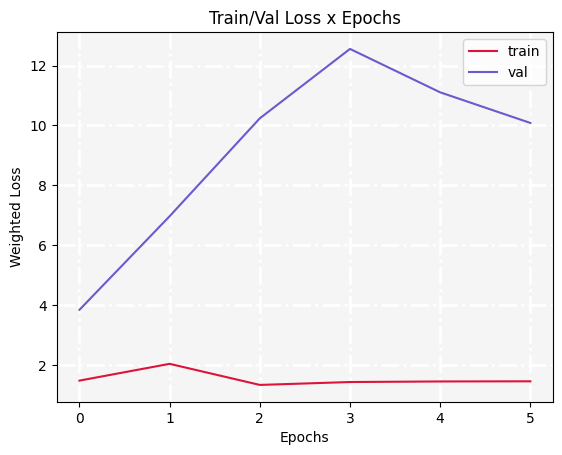

In [3]:
import pickle
import matplotlib.pyplot as plt

with open(f"{MODEL_PATH}/history", "rb") as f:
    h = pickle.load(f)
plt.xlabel("Epochs")
plt.ylabel("Weighted Loss")
plt.gca().set_facecolor("whitesmoke")
# plt.gca().set_ylim(0, 1)
plt.grid(color='w', linewidth=2, linestyle='-.')
plt.plot(h['loss'], c='crimson')
plt.plot(h['val_loss'], c='slateblue')
plt.legend(['train', 'val'])

plt.title("Train/Val Loss x Epochs")

# Test 

In [14]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

with open(f"{MODEL_PATH}/checkpoint/test_metrics", "rb") as f:
    var = pickle.load(f)

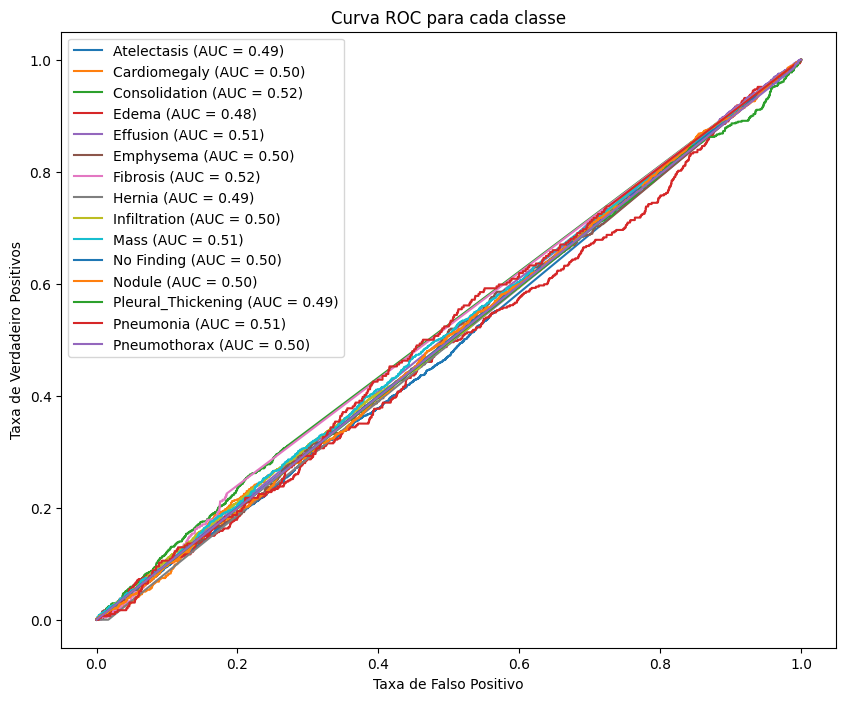

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve

# Calculando a curva AUC
plt.figure(figsize=(10, 8))
# Plotando as curvas ROC
for i in range(len(var['labels'])):
    fpr, tpr, _ = roc_curve(var['groun_truth'][:, i], var['predictions'][:, i])
    plt.plot(fpr, tpr, label=var['labels'][i] + ' (AUC = {:.2f})'.format(var['auc_scores'][i]))

# Adicionando legendas e título ao gráfico
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivos')
plt.title('Curva ROC para cada classe')
plt.legend()

# Exibindo o gráfico
plt.show()
plt.savefig('curva-rock.png', dpi=80)